# Cleaning & Exploratory Data Analysis of the libraries data
This notebook is for initial exploration of the four datasets associated with this challenge. 

## imports 

In [1]:
import os, sys, glob # for loading, saving and manipulating files on disk
from pathlib import Path # Path allows us to list directory paths in a manner that's not affected by the OS the notebook is being run on 

import pandas as pd # to work with csv files as dataframes 
import numpy as np # for mathematical and scientific computations 

import matplotlib.pyplot as plt # for plots 
import seaborn as sns # also for plotting, it's a wrapper for several matplotlib functions, making them more accessible 

## loading data

In [2]:
data_dir = Path.home()/'projects'/'billups_data_challenge'/'Data Challenge' # specifies the directory with data files
out_dir = data_dir.parent/'cleaned_data' # directory for storing intermediate outputs such as cleaned data
out_dir.mkdir(exist_ok=True) #creating the output directory, while making sure it's not overwritten if it already exists

In [3]:
lib_df = pd.read_csv(data_dir/'libraries.csv')

## investigating the data

### visual inspection

In [4]:
lib_df.shape # checking the size of the data

(18, 6)

In [5]:
lib_df # since the dataset only has 18 rows, I can visually inspect them all. If this were a larger dataset, I'd be using lib_df.sample(5)

,id,name,street_address,city,region,postal_code
0,226-222@5xc-kc4-fpv,Multnomah County Library Capitol Hill,10723 SW capitol Hwy,Portland,OR,97219
1,23v-222@5xc-jv7-v4v,Multnomah County Library Northwest,2300 NW Thurman St,NaN,or,NaN
2,222-222@5xc-jvf-skf,Multnomah County Library St Johns,7510 N Charleston Ave,portland,or,97203
3,227-222@5xc-jww-btv,Multnomah County Library Hillsdale,1525 SW Sunset blvd,Portland,or,-97239
4,22d-222@5xc-kcy-8sq,Multnomah County Library Sellwood Moreland,7860 SE 13th AVE,Portland,OR,97202
5,223-222@5xc-jxr-tgk,MULTNOMAH County Library Woodstock,6008 se 49TH AVE,Portland,OR,-97206
6,zzw-224@5xc-jwv-2rk,Multnomah County Library Central,801 SW 10th Ave,Portland,NaN,97205
7,zzw-223@5xc-jv7-ct9,Friends OF the multnomah COUNTY Library,522 SW 5th Ave,NaN,OR,97204
8,226-222@5xc-jxj-7yv,Multnomah County Library Belmont,1038 SE CESAR E CHAVEZ blvd,Portland,OR,97214
9,zzw-222@5xc-knn-c5z,Multnomah County Library Holgate,7905 SE Holgate Blvd,Portland,OR,NaN


Here I see the following problems with the data, that require cleaning: 
- the case is not the same across rows for name, street_address, city, and region 
- possible presence of leading and trailing whitespaces
- postal_code has non-numeric unwanted characters
- NaN values: for city and region I'd like to impute them with 'Portland' and 'OR' respectively. My reasoning behind this is that the problem statement mention this is a local library, additionally all remaining branches are in Portland, OR, so I feel safe making the assumption about null values. 

#### filling in missing values for city and region
Since the problem statement mentioned that this data pertains to a local library, and since all branches are in Portland, OR. I assume that the missing city refers to Portland and the missing region refers to OR, and replace NaNs with these values

In [6]:
lib_df['city'].fillna(value='Portland', inplace=True)
lib_df['region'].fillna(value='OR', inplace=True)

#### removing leading/trailing white spaces, and converting strings to title (upper) case for name, street_address, city (region)

In [7]:
lib_df[['name', 'street_address', 'city', 'region']] = lib_df[['name', 'street_address', 'city', 'region']].apply(lambda x: x.str.strip())
lib_df[['name', 'street_address', 'city']] = lib_df[['name', 'street_address', 'city']].apply(lambda x: x.str.title())
lib_df['region'] = lib_df['region'].str.upper()

#### cleaning up the address
I consider the address an important variable, as one of my hypothesis is that distance of the library from the patron address affects the likelihood of a timely return. So, I want to convert the address in a location (lat-long). In order to be able to geocode the address, I need to take the following steps to clean it: 
- Capitalize the direction component in the street_address (eg: NE, N, SW)
- Clean postal_code so it consists of 5-digit numbers
- Combine street_address, city, region, postal_code to get a "full_address" column that can be used for geocoding

##### capitalizing the direction component in street addresses 
I can see that the direction component comes after the first whitespace in the string in the street_address column, I will utilize this to format the direction component

In [8]:
street_address= lib_df['street_address'].str.split(expand=True, n=2)
street_address[1]= street_address[1].str.upper()
street_address['new_address'] = street_address[0]+' '+street_address[1]+' '+street_address[2]
lib_df['street_address'] = street_address['new_address']

##### cleaning up the postal_code column values

In [9]:
lib_df['postal_code'] = lib_df['postal_code'].str.replace('[^\d]', '')

/Users/garima/miniconda3/envs/reloc/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


##### creating a full_address column for geocoding

In [10]:
lib_df['full_address'] = lib_df['street_address']+' '+lib_df['city']+' '+lib_df['region'] + ' '+ lib_df['postal_code'].fillna('')

In [11]:
lib_df

,id,name,street_address,city,region,postal_code,full_address
0,226-222@5xc-kc4-fpv,Multnomah County Library Capitol Hill,10723 SW Capitol Hwy,Portland,OR,97219,10723 SW Capitol Hwy Portland OR 97219
1,23v-222@5xc-jv7-v4v,Multnomah County Library Northwest,2300 NW Thurman St,Portland,OR,NaN,2300 NW Thurman St Portland OR
2,222-222@5xc-jvf-skf,Multnomah County Library St Johns,7510 N Charleston Ave,Portland,OR,97203,7510 N Charleston Ave Portland OR 97203
3,227-222@5xc-jww-btv,Multnomah County Library Hillsdale,1525 SW Sunset Blvd,Portland,OR,97239,1525 SW Sunset Blvd Portland OR 97239
4,22d-222@5xc-kcy-8sq,Multnomah County Library Sellwood Moreland,7860 SE 13Th Ave,Portland,OR,97202,7860 SE 13Th Ave Portland OR 97202
5,223-222@5xc-jxr-tgk,Multnomah County Library Woodstock,6008 SE 49Th Ave,Portland,OR,97206,6008 SE 49Th Ave Portland OR 97206
6,zzw-224@5xc-jwv-2rk,Multnomah County Library Central,801 SW 10Th Ave,Portland,OR,97205,801 SW 10Th Ave Portland OR 97205
7,zzw-223@5xc-jv7-ct9,Friends Of The Multnomah County Library,522 SW 5Th Ave,Portland,OR,97204,522 SW 5Th Ave Portland OR 97204
8,226-222@5xc-jxj-7yv,Multnomah County Library Belmont,1038 SE Cesar E Chavez Blvd,Portland,OR,97214,1038 SE Cesar E Chavez Blvd Portland OR 97214
9,zzw-222@5xc-knn-c5z,Multnomah County Library Holgate,7905 SE Holgate Blvd,Portland,OR,NaN,7905 SE Holgate Blvd Portland OR


### examining missing values

In [12]:
lib_df.isna().sum() # to get total number of missing values per column

id                0
name              0
street_address    0
city              0
region            0
postal_code       3
full_address      0
dtype: int64

Note that we have already imputed missing values for city and region, under the assumption that all libraries belong to Portland, OR. After that, we only have one column with missing values, which is the postal_code column. 

### examining unique values

In [13]:
lib_df.describe()

,id,name,street_address,city,region,postal_code,full_address
count,18,18,18,18,18,15,18
unique,18,18,18,1,1,12,18
top,22c-222@5xc-jwj-pvz,Multnomah County Library,2300 NW Thurman St,Portland,OR,97212,1038 SE Cesar E Chavez Blvd Portland OR 97214
freq,1,1,1,18,18,3,1


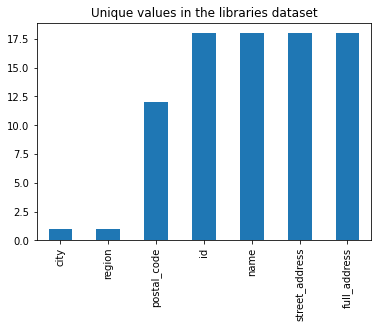

In [14]:
lib_df.nunique().sort_values().plot.bar(title='Unique values in the libraries dataset'); 

- all libraries are in Portland, Oregon
- some postal_codes have more than one library
- each row in libraries.csv corresponds to a different library (branch)

#### closer look at postal_code
There are 18 libraries, 3 of which don't have a recorded postal code, but only 12 unique postal codes. Thus, for one or more postal codes there is more than one library. I want to examine this further to make sure there are no recording errors. 

In [15]:
lib_df.postal_code.value_counts()

97212    3
97217    2
97206    1
97219    1
97214    1
97213    1
97203    1
97233    1
97239    1
97204    1
97202    1
97205    1
Name: postal_code, dtype: int64

In [16]:
lib_df[lib_df['postal_code'].isin(['97212', '97217'])]

,id,name,street_address,city,region,postal_code,full_address
11,228-222@5xc-jtz-hwk,Multnomah County Library,205 NE Russell St,Portland,OR,97212,205 NE Russell St Portland OR 97212
13,222-222@5xc-jv5-nt9,Multnomah County Library North Portland,512 N Killingsworth St,Portland,OR,97217,512 N Killingsworth St Portland OR 97217
14,zzw-222@5xc-jv4-789,Multnomah County Library Albina,3605 NE 15Th Ave,Portland,OR,97212,3605 NE 15Th Ave Portland OR 97212
15,222-222@5xc-jxp-rp9,Multnomah County Library Hollywood Library,4040 NE Tillamook St,Portland,OR,97212,4040 NE Tillamook St Portland OR 97212
16,22c-222@5xc-jwj-pvz,Multnomah County Library Kenton,8226 N Denver Ave,Portland,OR,97217,8226 N Denver Ave Portland OR 97217


- we do have 3 different libraries in the 97212 area, and 2 different libraries in the 97217 area

## geocoding library addresses

for large-scale geocoding in the past, I've used google's geocoding API. However, here I wanted to use something that doesn't require an API key, so I decided to use geopy. [This](https://towardsdatascience.com/geocode-with-python-161ec1e62b89) medium article provided me with helpful information about geocoding with geopy. 

In [17]:
from geopy import Nominatim
locator = Nominatim(user_agent='myGeocoder')

In [18]:
lib_df['geocoded_address'] = lib_df['full_address'].apply(lambda x: locator.geocode(x).address)
lib_df['lat'] = lib_df['full_address'].apply(lambda x: locator.geocode(x).latitude)
lib_df['long'] = lib_df['full_address'].apply(lambda x: locator.geocode(x).longitude)

In [19]:
lib_df

,id,name,street_address,city,region,postal_code,full_address,geocoded_address,lat,long
0,226-222@5xc-kc4-fpv,Multnomah County Library Capitol Hill,10723 SW Capitol Hwy,Portland,OR,97219,10723 SW Capitol Hwy Portland OR 97219,"Capitol Hill Library, 10723, Southwest Capitol...",45.448003,-122.725449
1,23v-222@5xc-jv7-v4v,Multnomah County Library Northwest,2300 NW Thurman St,Portland,OR,NaN,2300 NW Thurman St Portland OR,"Northwest Library, 2300, Northwest Thurman Str...",45.535336,-122.699145
2,222-222@5xc-jvf-skf,Multnomah County Library St Johns,7510 N Charleston Ave,Portland,OR,97203,7510 N Charleston Ave Portland OR 97203,"Saint Johns Library, 7510, North Charleston Av...",45.590036,-122.751053
3,227-222@5xc-jww-btv,Multnomah County Library Hillsdale,1525 SW Sunset Blvd,Portland,OR,97239,1525 SW Sunset Blvd Portland OR 97239,"Hillsdale Library, 1525, Southwest Sunset Boul...",45.479834,-122.694087
4,22d-222@5xc-kcy-8sq,Multnomah County Library Sellwood Moreland,7860 SE 13Th Ave,Portland,OR,97202,7860 SE 13Th Ave Portland OR 97202,"Sellwood Moreland Library, 7860, Southeast 13t...",45.467632,-122.652746
5,223-222@5xc-jxr-tgk,Multnomah County Library Woodstock,6008 SE 49Th Ave,Portland,OR,97206,6008 SE 49Th Ave Portland OR 97206,"Woodstock Library, 6008, Southeast 49th Avenue...",45.479005,-122.612107
6,zzw-224@5xc-jwv-2rk,Multnomah County Library Central,801 SW 10Th Ave,Portland,OR,97205,801 SW 10Th Ave Portland OR 97205,"Central Library, 801, Southwest 10th Avenue, U...",45.519201,-122.683202
7,zzw-223@5xc-jv7-ct9,Friends Of The Multnomah County Library,522 SW 5Th Ave,Portland,OR,97204,522 SW 5Th Ave Portland OR 97204,"Yeon Building, 522, Southwest 5th Avenue, Down...",45.519585,-122.676793
8,226-222@5xc-jxj-7yv,Multnomah County Library Belmont,1038 SE Cesar E Chavez Blvd,Portland,OR,97214,1038 SE Cesar E Chavez Blvd Portland OR 97214,"Belmont Library, 1038, Southeast César E. Cháv...",45.515267,-122.622676
9,zzw-222@5xc-knn-c5z,Multnomah County Library Holgate,7905 SE Holgate Blvd,Portland,OR,NaN,7905 SE Holgate Blvd Portland OR,"Holgate Library, 7905, Southeast Holgate Boule...",45.490566,-122.582281


## visualizing the spread of library location on the map of Portland OR

In [20]:
import folium # to fetch the map of Portland

In [27]:
library_map = folium.Map(location=[45.515,-122.67], tiles='cartodbpositron', zoom_start=11);
lib_df.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]]).add_to(library_map), axis=1);
library_map

0     <folium.vector_layers.CircleMarker object at 0...
1     <folium.vector_layers.CircleMarker object at 0...
2     <folium.vector_layers.CircleMarker object at 0...
3     <folium.vector_layers.CircleMarker object at 0...
4     <folium.vector_layers.CircleMarker object at 0...
5     <folium.vector_layers.CircleMarker object at 0...
6     <folium.vector_layers.CircleMarker object at 0...
7     <folium.vector_layers.CircleMarker object at 0...
8     <folium.vector_layers.CircleMarker object at 0...
9     <folium.vector_layers.CircleMarker object at 0...
10    <folium.vector_layers.CircleMarker object at 0...
11    <folium.vector_layers.CircleMarker object at 0...
12    <folium.vector_layers.CircleMarker object at 0...
13    <folium.vector_layers.CircleMarker object at 0...
14    <folium.vector_layers.CircleMarker object at 0...
15    <folium.vector_layers.CircleMarker object at 0...
16    <folium.vector_layers.CircleMarker object at 0...
17    <folium.vector_layers.CircleMarker object 

## saving cleaned and geocoded libraries dataframe to disk

In [28]:
lib_df.to_csv(out_dir/'libraries_cleaned_geocoded.csv', index=False)